# 개요

뇌종양은 뇌에 비정상적인 세포 덩어리 또는 성장으로, 다양한 유형의 뇌종양이 존재합니다. 일부 뇌종양은 비암성(양성)이고 일부 뇌종양은 암성(악성)입니다. 뇌종양은 뇌에서 시작되거나(원발성 뇌종양), 신체의 다른 부위에서 암이 시작되어 뇌로 전이되어 이차성(전이성) 뇌종양으로 나타날 수 있습니다.

뇌종양이 자라는 속도는 매우 다양합니다. 성장 속도와 뇌종양의 위치에 따라 신경계 기능에 미치는 영향이 결정됩니다.

뇌종양 치료 옵션은 뇌종양의 종류와 크기 및 위치에 따라 달라집니다.  
Source credits : Mayo Clinic

# Image Segmentation 이란?

이미지 분할의 목적은 이미지의 각 픽셀을 예측하여 이미지의 각 픽셀이 나타내는 클래스로 분류하는 것입니다.  
이 노트북에서는 U자형 아키텍처(케라 단위)인 U-Net 모델을 구현하겠습니다. 또한 이 모델을 뇌 MRI 종양 검출 문제에 적용하여 그 성능을 살펴보겠습니다.

# 라이브러리

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob

import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from IPython.display import Image
from skimage import io
# io 모듈은 이미지 파일을 다양한 포맷으로 읽어들이는 함수들을 제공합니다.
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform 
# glorot_uniform은 Xavier Glorot가 제안한 가중치 초기화 방법 중 하나입니다.
# 모든 가중치를 균등하게 분포시키는 방법으로, Xavier 초기화라고도 불립니다.
# 이 방법은 입력 뉴런 수와 출력 뉴런 수를 고려하여 가중치를 초기화합니다.
# 이 방법으로 초기화한 가중치는 분산이 적당하며, 모델의 학습이 잘 이루어집니다.
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
# ReduceLROnPlateau는 검증 손실이 더 이상 개선되지 않을 때, 학습률을 동적으로 감소시키는 콜백입니다.
# 이 콜백은 검증 손실이 patience 만큼의 epoch 동안 개선되지 않으면 factor 만큼의 학습률 감소를 수행합니다.
# LearningRateScheduler는 epoch이 진행됨에 따라 학습률을 동적으로 변경할 수 있는 콜백입니다. 
# 이 콜백을 사용하면 epoch마다 학습률을 변경하거나, 특정 epoch 이후에 학습률을 감소시킬 수 있습니다.
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
# Lambda는 함수를 래핑하여 케라스 층으로 만드는 역할을 합니다. 
# Lambda 층을 사용하면 사용자 정의 함수를 케라스 모델 내에서 층으로 활용할 수 있습니다.
# concatenate는 tensorflow.keras.layers 모듈에 정의된 층(layer) 중 하나입니다. 
# 이 층은 여러 개의 입력을 받아, 이를 연결(concatenate)한 결과를 출력하는 역할을 합니다. 이 층을 사용하면 다중 입력 모델을 구현할 수 있습니다.
from tensorflow.keras.layers.experimental import preprocessing
# 이 모듈에서 제공하는 층들 중 일부는 다음과 같습니다.
# Resizing: 이미지 크기를 변경합니다.
# Rescaling: 이미지의 픽셀값 범위를 조정합니다.
# Normalization: 입력 데이터를 정규화합니다.
# RandomFlip: 입력 데이터를 무작위로 좌우 또는 상하로 뒤집습니다.
# RandomRotation: 입력 데이터를 무작위로 회전시킵니다.
# RandomZoom: 입력 데이터를 무작위로 확대 또는 축소합니다.
from keras.utils.vis_utils import plot_model
# keras.utils.vis_utils 모듈의 plot_model 함수는 케라스(Keras) 모델의 그래프 구조를 시각화해주는 함수입니다. 
# 이 함수를 사용하면 모델의 레이어들과 각 레이어들간의 연결 정보를 시각적으로 확인할 수 있습니다.
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
# tensorflow.keras.backend 모듈은 케라스(Keras) 백엔드 함수를 제공합니다. 
# 케라스 백엔드 함수는 다양한 수학 연산과 텐서 조작 작업을 수행하는 데 사용됩니다.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ImageDataGenerator 클래스는 이미지 데이터를 효율적으로 처리할 수 있는 제너레이터(generator)를 생성하는 데 사용됩니다. 
# ImageDataGenerator 클래스는 이미지 데이터의 전처리(preprocessing)를 자동화하고 데이터를 증강(augmentation)하여 데이터셋을 확장할 수 있습니다.
from tensorflow.keras.utils import plot_model
# tensorflow.keras.utils 패키지의 plot_model 함수는 TensorFlow 2.0 이상에서 케라스 모델의 시각화를 위한 권장 함수입니다. 
# 반면, keras.utils.vis_utils 모듈의 plot_model 함수는 TensorFlow 1.x에서 케라스 모델의 시각화를 위해 사용할 수 있습니다.

from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [5]:
# data 폴더에 압축 풀기
import zipfile
zip_file = 'archive.zip'
destination_folder = 'data'

if not os.path.exists(destination_folder):
    os.mkdir(destination_folder)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

In [7]:
img_data = pd.read_csv('data/lgg-mri-segmentation/kaggle_3m/data.csv')
img_data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


해당 데이터에서 컬럼의 의미는 다음과 같습니다.

**RNASeqCluster** : RNA-seq 데이터를 기반으로 한 종양 클러스터링 결과  
**MethylationCluster** : DNA 메틸레이션 데이터를 기반으로 한 종양 클러스터링 결과  
**miRNACluster** : 마이크로 RNA-seq 데이터를 기반으로 한 종양 클러스터링 결과  
**CNCluster** : DNA 복제수 변화 데이터를 기반으로 한 종양 클러스터링 결과  
**RPPACluster** : RPPA(protein array) 데이터를 기반으로 한 종양 클러스터링 결과  
**OncosignCluster** : 종양 기호학(oncosignaling) 데이터를 기반으로 한 종양 클러스터링 결과  
**COCCluster** : 일반적인 적색/흰색 혈액세포를 기반으로 한 종양 클러스터링 결과  
**histological_type** : 조직학적 종양 유형  
**neoplasm_histologic_grade** : 종양 조직학적 학급  
**tumor_tissue_site** : 종양 발생 위치  
**laterality** : 악성종양 발생 부위의 좌우측  
**tumor_location** : 종양 발생 위치  
**gender** : 성별  
**age_at_initial_pathologic** : 조직학적 진단시 나이  
**race** : 인종  
**ethnicity** : 민족성  
**death01** : 환자 사망 여부 (1: 사망, 0: 생존)

In [8]:
img_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [9]:
img_data.shape

(110, 18)

In [16]:
data_path = []
for sub_dir_path in glob.glob('data/lgg-mri-segmentation/kaggle_3m/'+'*'):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            mask_path = sub_dir_path + '/' + filename
            data_path.extend([dir_name, mask_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: 'data/lgg-mri-segmentation/kaggle_3m/data.csv'
[Errno 20] Not a directory: 'data/lgg-mri-segmentation/kaggle_3m/README.md'


In [12]:
filenames = data_path[::2]
masks = data_path[1::2]

In [13]:
df = pd.DataFrame(data={'patient_id':filenames, 'img_path':masks})
df

,patient_id,img_path
0,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
1,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
2,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
3,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
4,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
...,...,...
7853,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...
7854,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...
7855,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...
7856,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...


In [19]:
original_img = df[~df['img_path'].str.contains('mask')]
mask_img = df[df['img_path'].str.contains('mask')]

In [21]:
display(original_img, mask_img)

,patient_id,img_path
5,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
8,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
9,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
11,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
13,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
...,...,...
7847,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...
7849,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...
7851,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...
7855,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...


,patient_id,img_path
0,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
1,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
2,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
3,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
4,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
...,...,...
7850,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...
7852,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...
7853,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...
7854,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...


In [25]:
imgs = sorted(original_img['img_path'].values, key=lambda x : int(x[80:-4]))
masks = sorted(mask_img['img_path'].values, key=lambda x : int(x[80:-9]))

In [34]:
# idx = random.randint(0, len(imgs)-1)
# print('Image path:', imgs[idx], '\nMask path:', masks[idx])

Image path: data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_5.tif 
Mask path: data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_5_mask.tif


In [35]:
mri_df = pd.DataFrame({'patient_id':original_img.patient_id.values, 'img_path':imgs, 'mask_path':masks})
mri_df

,patient_id,img_path,mask_path
0,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
1,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_74...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_74...
2,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...
3,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A5...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A5...
4,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
...,...,...,...
3924,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...
3925,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...
3926,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...
3927,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...


In [46]:
def get_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0:
        return 1
    else:
        return 0

In [45]:
mri_df.head()

,patient_id,img_path,mask_path
0,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...
1,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_74...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_74...
2,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...
3,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A5...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A5...
4,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...


In [51]:
mri_df['mask'] = mri_df['mask_path'].apply(lambda x : get_diagnosis(x))
mri_df['mask_path'] = mri_df['mask_path'].apply(lambda x : str(x))

mri_df

,patient_id,img_path,mask_path,mask
0,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...,0
1,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_74...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_74...,0
2,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...,0
3,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A5...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A5...,0
4,TCGA_DU_5871_19941206,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_58...,0
...,...,...,...,...
3924,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...,0
3925,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...,0
3926,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...,0
3927,TCGA_HT_7690_19960312,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...,0


In [52]:
mri_df = mri_df.drop(columns='patient_id').copy()

In [53]:
mri_train, mri_test = train_test_split(mri_df, test_size=0.1)
mri_train, mri_val = train_test_split(mri_train, test_size=0.2)

print('Traing data shape is {0}'.format(mri_train.values.shape))
print('Test data shape is {0}'.format(mri_test.values.shape))
mri_train.sample(5)

Traing data shape is (2828, 3)
Test data shape is (393, 3)


,img_path,mask_path,mask
549,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_76...,0
1925,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...,data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A6...,1
2716,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_81...,data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_81...,1
2290,data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_61...,data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_61...,0
1350,data/lgg-mri-segmentation/kaggle_3m/TCGA_FG_66...,data/lgg-mri-segmentation/kaggle_3m/TCGA_FG_66...,0


# EDA

데이터 불균형 확인

Text(0.5, 1.0, 'Count of Tumour vs No Tumour')

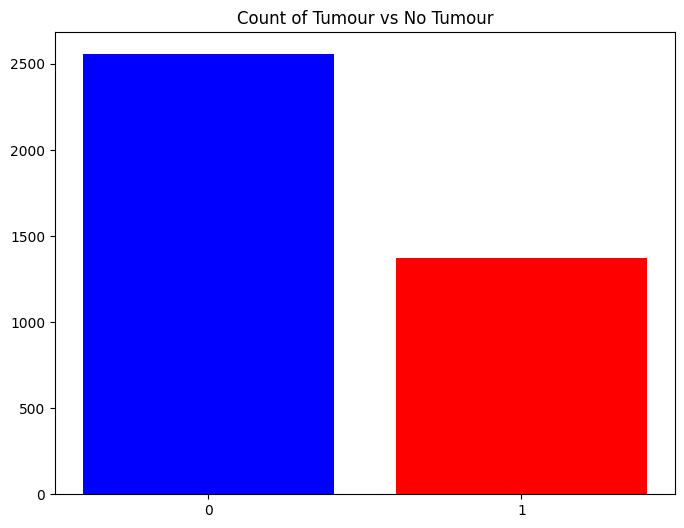

In [86]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(mri_df['mask'].value_counts().index, mri_df['mask'].value_counts().values, color=['b', 'r'])
ax.set_xticks([0, 1])
ax.set_title("Count of Tumour vs No Tumour")

In [88]:
mri_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

# 이미지 시각화

종양이 있는 뇌 MRI 시각화

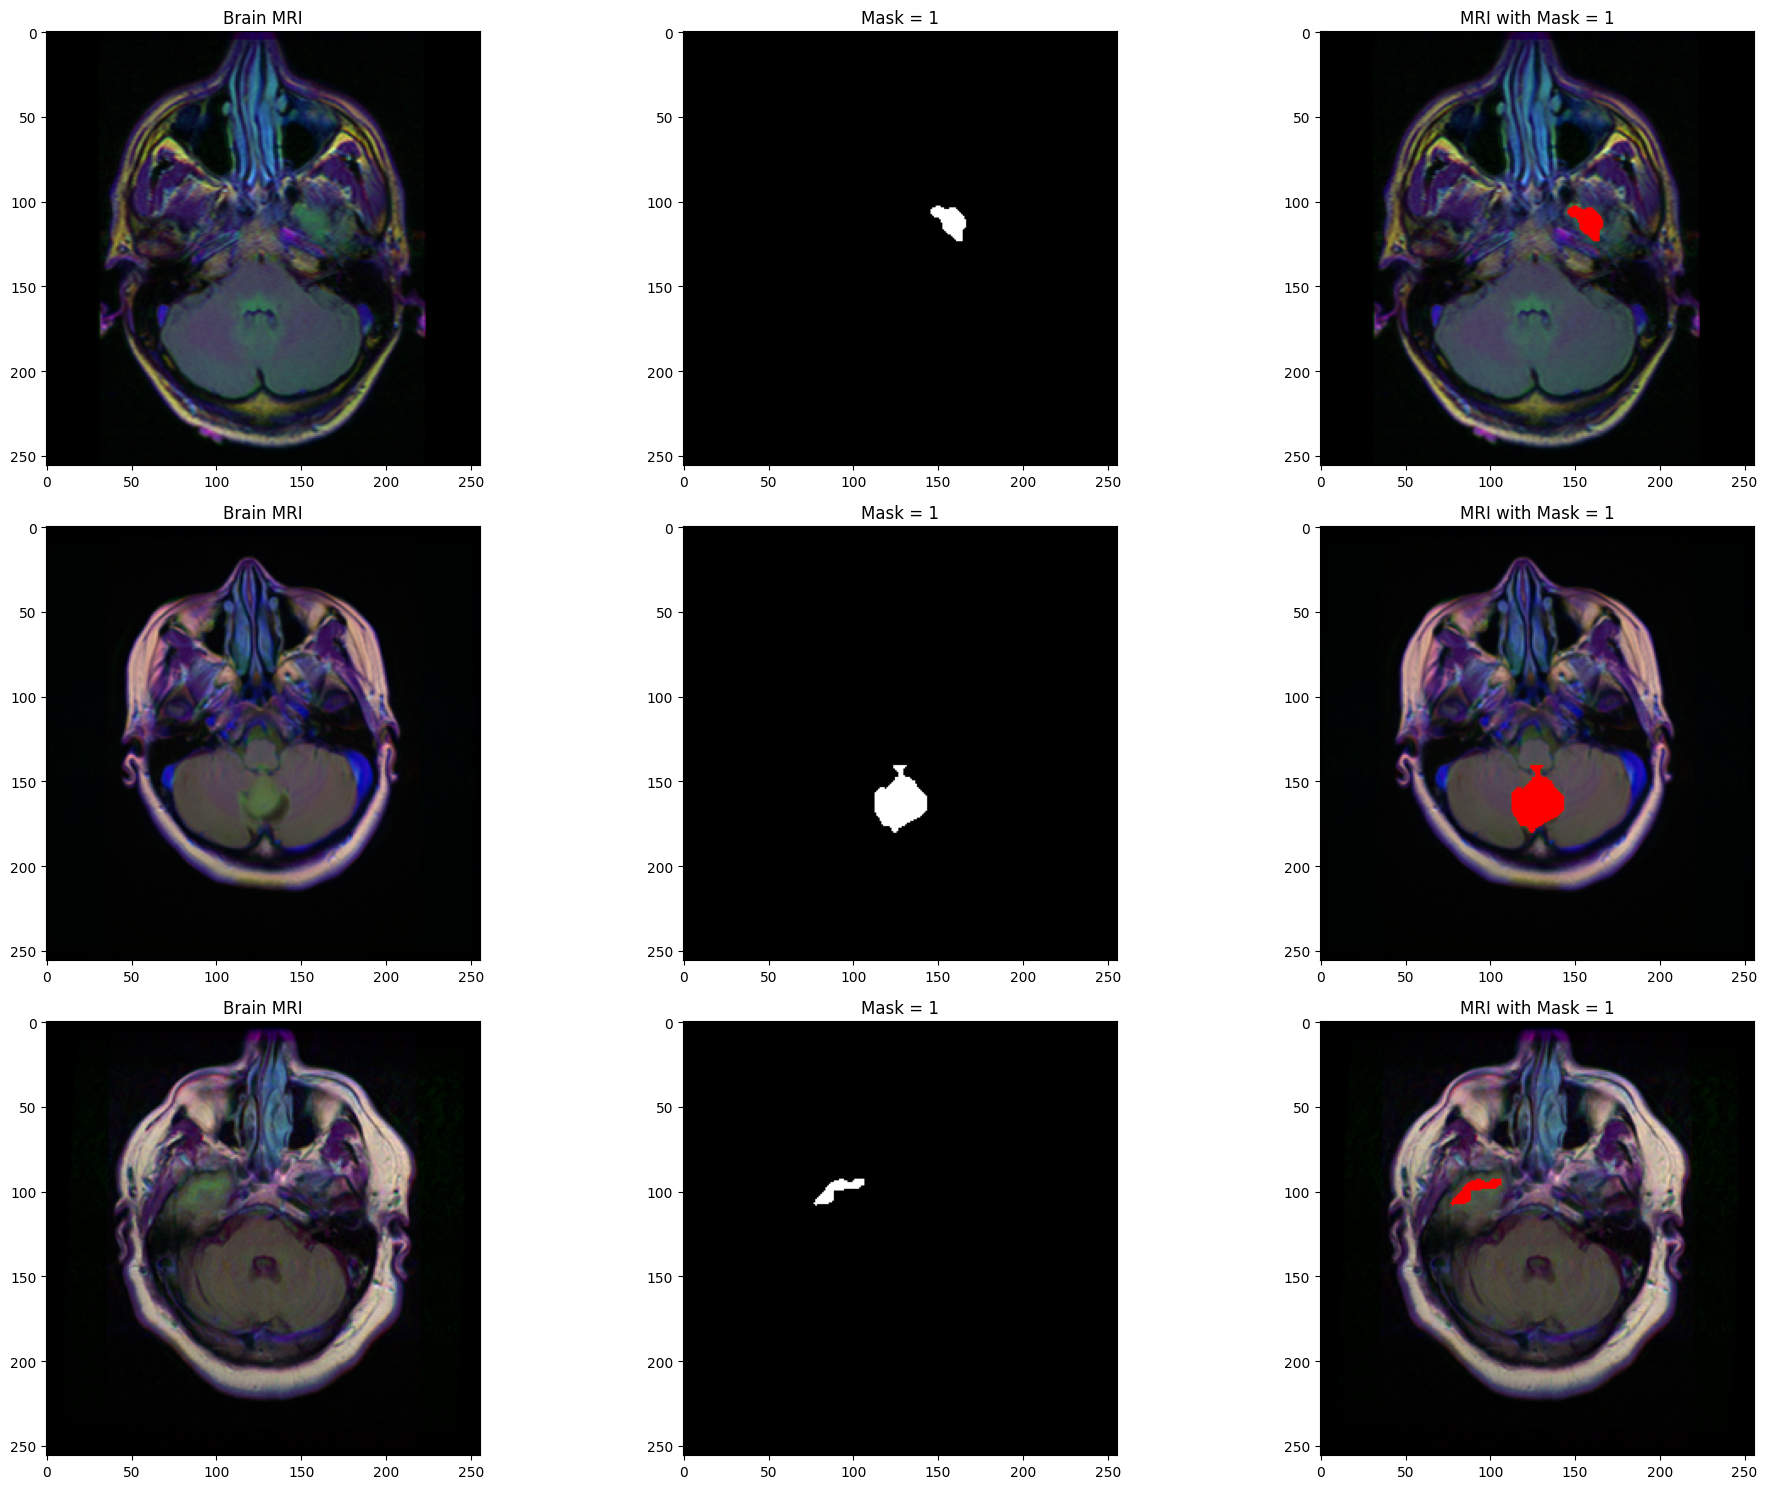

In [93]:
count = 0
i =0
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
for mask in mri_df['mask']:
    if mask==1:
        img = io.imread(mri_df.img_path[i])
        axs[count][0].title.set_text('Brain MRI')
        axs[count][0].imshow(img)

        mask = io.imread(mri_df.mask_path[i])
        axs[count][1].title.set_text('Mask = ' + str(mri_df['mask'][i]))
        axs[count][1].imshow(mask, cmap='gray')

        img[mask==255] = (255,0,0) 
        # img[mask==255]는 mask배열에서 값이 255인 위치들을 찾아서 그 위치에 해당하는 img의 값을 가져오는 것입니다.
        # 그 위치에 해당하는 img의 픽셀들의 RGB 값을 (255,0,0)으로 설정하는 것입니다. 
        # 즉, 마스크로 표시된 부분을 빨간색으로 표시하는 것입니다. 
        axs[count][2].title.set_text('MRI with Mask = ' + str(mri_df['mask'][i]))
        axs[count][2].imshow(img)
        count += 1
    i += 1
    if count==3:
        break

fig.tight_layout()

# 데이터 생성기

참조: UNet

In [100]:
from keras_preprocessing.image import ImageDataGenerator

In [101]:
def train_generator(data_frame, batch_size, aug_dict,
                    image_color_mode='rgb',
                    mask_color_mode='grayscale',
                    image_save_prefix='image',
                    mask_save_prefix='mask', 
                    save_to_dir=None,
                    target_size=(256, 256),
                    seed=1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe( # image_datagen.flow_from_dataframe()은 ImageDataGenerator 객체를 사용하여 데이터 프레임에서 이미지 데이터를 로드하는 함수입니다.
                      data_frame, # dataframe: 이미지 파일 경로와 레이블 정보를 포함하는 데이터프레임
                      x_col='img_path', # x_col: 이미지 파일 경로를 저장한 컬럼 이름
                      class_mode=None, # class_mode: 분류 작업에서 사용하는 레이블의 타입입니다. 이진 분류에서는 'binary', 다중 분류에서는 'categorical'로 설정합니다.
                      color_mode=image_color_mode,
                      target_size=target_size,
                      batch_size=batch_size,
                      save_to_dir=save_to_dir,
                      save_prefix=image_save_prefix, # save_prefix: 저장될 이미지 파일 이름의 접두어
                      seed=seed) # seed: 난수 시드값

    mask_generator = mask_datagen.flow_from_dataframe(
                     data_frame,
                     x_col='mask_path',
                     class_mode=None,
                     color_mode=mask_color_mode,
                     target_size=target_size,
                     batch_size=batch_size,
                     save_to_dir=save_to_dir,
                     save_prefix=mask_save_prefix,
                     seed=seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        # 이미지와 마스크 모두를 float32 타입으로 변환합니다.
        # 이미지 데이터의 값 범위를 0~1로 정규화합니다.
        # 마스크 데이터를 0과 1로 이진화합니다.
        yield (img, mask)

**yield 구문**  
yield 구문은 파이썬에서 함수를 생성자(generator)로 바꾸어 주는 기능을 제공합니다. 일반적인 함수와 달리, yield 구문이 포함된 함수는 호출될 때 함수가 즉시 실행되지 않고, 대신 이터레이터(iterator) 객체를 반환합니다.

이후 이터레이터 객체의 __next__() 메서드를 호출하면, 해당 함수의 yield 구문이 실행될 때까지 코드가 실행되며, yield 구문이 실행되면 그 결과를 반환합니다. 이후 다시 __next__() 메서드를 호출하면 이전에 실행된 yield 구문 다음의 코드부터 실행되며, 다음 yield 구문을 만날 때까지 이어집니다.

즉, yield를 사용하면 함수를 호출할 때마다 함수 내에서 실행되는 모든 상태가 유지됩니다. 이는 대규모 데이터 처리와 같은 상황에서 유용합니다. yield를 사용하면 데이터가 함수 내부에 모두 적재되지 않고, 필요할 때마다 호출되어 처리되므로, 메모리 부담을 줄일 수 있습니다.

In [104]:
def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

In [105]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(mri_train, 32, train_generator_args, target_size=(256, 256))

val_gen = train_generator(mri_val, 32, dict(), target_size=(256, 256))

# UNet 아키텍처

UNet은 아키텍처의 모양(U자형)에서 따온 이름입니다. UNet 모델은 특히 의료 관련 문제에서 이미지 분할 문제를 해결하는 데 사용됩니다.

위의 아키텍처에서 입력 레이어는 572x572x1 차원을 갖습니다. 1열 차원은 입력이 흑백 이미지임을 나타냅니다. 입력 크기가 572x572x3인 경우 입력 이미지는 RGB 컬러 이미지입니다. 입력 레이어 이후에는 이 UNet 아키텍처를 4가지 부분으로 나눌 수 있습니다.

인코더 부분(수축 경로)
업샘플링2D
디코더 부분(확장 경로)
연결 건너뛰기(잔여 연결)

각 파트에 대해 간략히 설명합니다:
인코더 부분 U자형 아키텍처의 초기 절반은 컨트랙팅 경로(인코더 부분)입니다. 계약 경로라는 이름에서 알 수 있듯이 입력 이미지의 크기는 2 개의 Conv2D 3X3 커널 크기, ReLU 활성화 및 필터=64에 이어 Maxpool2D 레이어(크기를 2로 나누어 축소)를 통과하면서 계속 줄어듭니다. 이제 다시 2 - Conv2D 레이어(128개 필터)와 Maxpooling2D 1개, 2 - Conv2D 레이어(256개 필터)와 Maxpooling2D 1개가 레이어를 통해 출력 치수를 완전히 축소합니다. 이는 각 레이어를 통해 이미지를 확대하는 것과 유사합니다.

업샘플링2D 업샘플링2D 레이어는 행 값을 두 번 복제하여 레이어 출력 차원을 업샘플링하며, 업샘플링2D와 축소 경로의 연결은 여기에서 Expanding 경로로 이어집니다. 업샘플링 레이어는 디코더 파트에서 2개의 컨버팅 2D 레이어 뒤에 존재하며, 인코더 파트에서 맥스풀링이 존재하는 것과 유사합니다.

디코더 경로 U자형 아키텍처의 후반부는 Expanding 경로(디코더 부분)입니다. Expanding 경로라는 이름에서 알 수 있듯이 이미지의 크기는 2 Conv2D 3X3 커널 크기, ReLU 활성화 및 필터=512를 거쳐 Upsampling2D 레이어(복제 크기를 2로 나눈 값)를 통과하면서 계속 확장됩니다. 이제 다시 2 - Conv2D 레이어(256개 필터)와 업샘플링2D 1개, 2 - Conv2D 레이어(128개 필터)와 업샘플링2D 1개, 2 - Conv2D 레이어(64개 필터)는 레이어를 통해 출력 차원을 완전히 확장합니다. 이는 각 레이어를 통해 이미지를 확대하는 것과 유사합니다.

연결 건너뛰기(잔여 연결) 연결 건너뛰기(잔여 연결) 별칭은 인코더의 각 2개의 Conv2D 레이어 뒤에 디코더 부분의 동일한 모양의 차원 레이어에 대한 아이덴티티 매핑이 존재합니다. 위의 아키텍처에서는 복사 및 자르기가 잔여 연결 작업을 수행하며, 연결 레이어는 이 두 레이어를 추가하는 작업을 수행합니다. 이 연결 건너뛰기는 최악의 경우에도 모델에 어떤 식으로든 해를 끼치지는 않지만 모델의 출력에 확실히 인위적인 영향을 미칩니다.

마지막으로 디코더 부분은 필터 2가 포함된 출력 세분화 맵으로 끝납니다. 이 레이어는 다시 시그모이드 활성화와 필터 1이 포함된 Conv2D를 통과합니다. 출력은 각 픽셀에 종양이 있는지 없는지를 분류합니다.

UNet 모델 빌드 아래 빌드된 모델에서는 두 번째 컨볼루션 레이어 뒤에 축이 3인 배치 정규화 레이어가 추가되어 "내부 공분산 이동"을 방지하고, 두 번째 컨볼루션 레이어 대신 활성화 레이어 "relu"가 여기에 추가됩니다.

참조: UNet

In [106]:
def unet(pretrained_weights = None, input_size = (256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    bn_1 = BatchNormalization(axis=3)(conv1)
    act_1 = Activation('relu')(bn_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act_1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    bn_2 = BatchNormalization(axis=3)(conv2)
    act_2 = Activation('relu')(bn_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act_2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    bn_3 = BatchNormalization(axis=3)(conv3)
    act_3 = Activation('relu')(bn_3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act_3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    bn_4 = BatchNormalization(axis=3)(conv4)
    act_4 = Activation('relu')(bn_4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(act_4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    bn_5 = BatchNormalization(axis=3)(conv5)
    act_5 = Activation('relu')(bn_5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    bn_6 = BatchNormalization(axis=3)(conv6)
    act_6 = Activation('relu')(bn_6)
    
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    bn_7 = BatchNormalization(axis=3)(conv7)
    act_7 = Activation('relu')(bn_7)
    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    bn_8 = BatchNormalization(axis=3)(conv8)
    act_8 = Activation('relu')(bn_8)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    bn_9 = BatchNormalization(axis=3)(conv9)
    act_9 = Activation('relu')(bn_9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(act_9)

    model = model = Model(inputs=[inputs] , outputs = [conv10])    
    return model

In [107]:
model = unet()
model.summary()

2023-04-30 13:45:33.762519: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 13:45:34.453127: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1553] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14445 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:e0:00.0, compute capability: 7.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

# UNet Model architecture

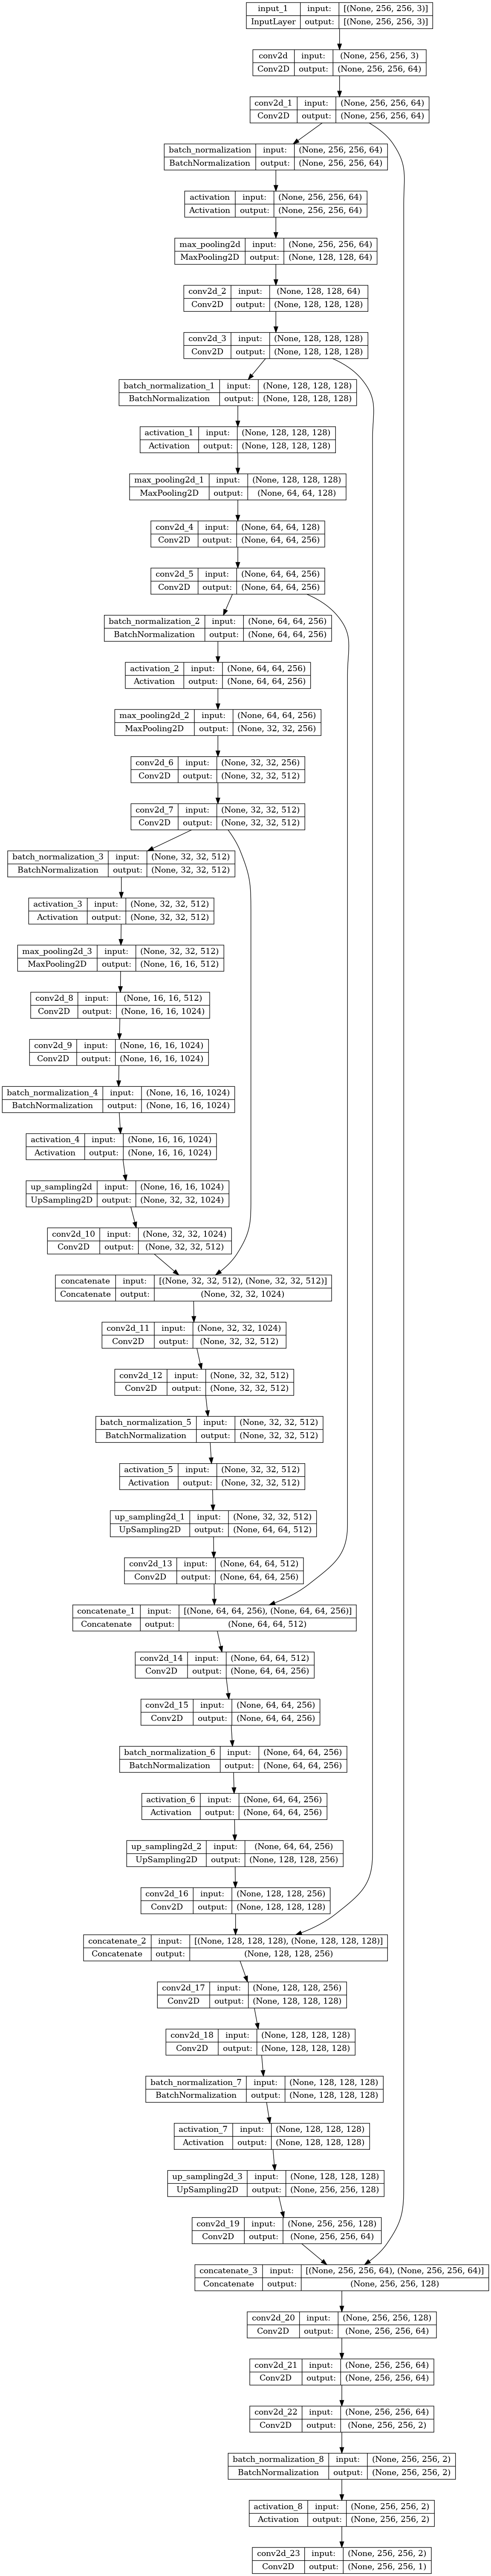

In [108]:
plot_model(model, to_file='unet_model.png', show_shapes=True)
Image("unet_model.png")

# Callbacks

사용되는 콜백은 다음과 같습니다.

* 학습률 감소  
* 조기 중지  
* 모델 체크포인트  

In [109]:
lr_reduction = ReduceLROnPlateau(monitor='val_iou',patience=8, verbose=1,
                                 factor=0.4, min_lr=0.0001)

early_stop = EarlyStopping(monitor='val_iou', min_delta=0.00001, patience=6, 
                           mode='auto', restore_best_weights=True)

model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', verbose=1,monitor='val_iou',
                                   save_best_only=True)

# 성능 지표

In [110]:
smooth =100
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [131]:
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# 모델 학습

In [132]:
EPOCH = 100
learning_rate = 1e-3

In [135]:
model.compile(optimizer=Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-3/32, amsgrad=False), 
              loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

In [136]:
history = model.fit(train_gen,steps_per_epoch=len(mri_train)/32,
                    epochs=EPOCH ,validation_data=val_gen,validation_steps=len(mri_val) / 32,
                    callbacks=[model_checkpoint])

Epoch 1/100


2023-04-30 14:39:39.144367: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-30 14:39:42.970284: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-30 14:39:43.377242: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 1/88 [..............................] - ETA: 16:45 - loss: 0.9700 - binary_accuracy: 0.9881 - iou: 0.0153 - dice_coef: 0.0300

2023-04-30 14:39:50.715793: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


89/88 [==============================] - ETA: 0s - loss: 0.9621 - binary_accuracy: 0.9896 - iou: 0.0194 - dice_coef: 0.0378Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_iou improved from inf to 0.01403, saving model to unet_membrane.hdf5
88/88 [==============================] - 129s 1s/step - loss: 0.9621 - binary_accuracy: 0.9896 - iou: 0.0194 - dice_coef: 0.0378 - val_loss: 0.9727 - val_binary_accuracy: 0.9899 - val_iou: 0.0140 - val_dice_coef: 0.0275
Epoch 2/100
89/88 [==============================] - ETA: 0s - loss: 0.9530 - binary_accuracy: 0.9898 - iou: 0.0244 - dice_coef: 0.0473
Epoch 2: val_iou did not improve from 0.01403
88/88 [==============================] - 68s 775ms/step - loss: 0.9530 - binary_accuracy: 0.9898 - iou: 0.0244 - dice_coef: 0.0473 - val_loss: 0.9555 - val_binary_accuracy: 0.9899 - val_iou: 0.0224 - val_dice_coef: 0.0434
Epoch 3/100
89/88 [==============================] - ETA: 0s - loss: 0.9378 - binary_accuracy: 0

# 모델 저장

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model.h5')

In [ ]:
model_json = model.to_json()
with open("UNet-seg-model.json", "w") as json_file:
    json_file.write(model_json)

# 평가

In [ ]:
history.history.keys()

NameError: name 'history' is not defined

NameError: name 'history' is not defined

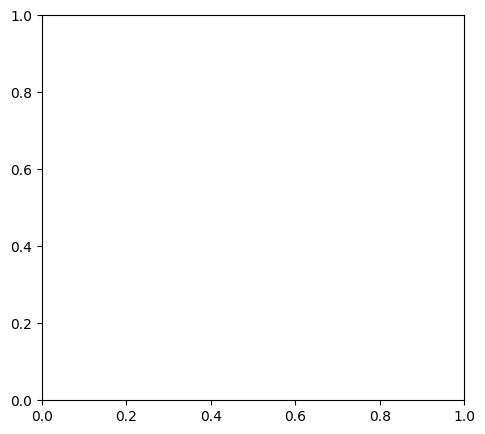

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['iou']);
plt.plot(history.history['val_iou']);
plt.title("Segmentation Model IOU Loss");
plt.ylabel("IOU loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

# 예측

In [ ]:
test_ids = list(mri_test.img_path)
test_mask = list(mri_test.mask_path)

In [ ]:
def prediction(test, model_seg):
  
    # empty list to store results
    mask, image_id,has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.img_path:
        

        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'img_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [ ]:
df_pred = prediction(mri_test, model)
df_pred

In [ ]:
df_pred = mri_test.merge(df_pred, on='img_path')
df_pred.head()

In [ ]:
count = 0
fig, axs = plt.subplots(3,5, figsize=(30,15))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.img_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Ground Truth')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.img_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with PREDICTED MASK')
        
        count +=1
    if (count==3):
        break

fig.tight_layout()

참조:

* UNet model Original creator Reference link  
* Kaggle Notebook - SAMUEL CORTINHAS